In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras import mixed_precision

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Dataset Path
DATA_DIR = "/content/drive/MyDrive/Healthy and unhealthy "


#set up data
IMG_HEIGHT = 192
IMG_WIDTH = 192
BATCH_SIZE = 64

train_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

train_data = train_gen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = train_gen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

mixed_precision.set_global_policy('mixed_float16')
print("Mixed Precision Enabled ")

Mounted at /content/drive
Found 11200 images belonging to 2 classes.
Found 2800 images belonging to 2 classes.
Mixed Precision Enabled 


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#build binary classifier
base_model = tf.keras.applications.EfficientNetB4(
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    weights='imagenet'
)
base_model.trainable = False  # Freeze base for Phase 1

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation='softmax')(x)  # binary classification

model = models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Add EarlyStopping and ReduceLROnPlateau
earlystop = EarlyStopping(patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=2, verbose=1)

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
#phase 1 train and save
history_phase1 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[earlystop, reduce_lr]
)

model.save("health_classifier_phase1.keras")
print("Phase 1 model saved as health_classifier_phase1.keras")



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 10575s 60s/step - accuracy: 0.5103 - loss: 0.7078 - val_accuracy: 0.5004 - val_loss: 0.6928 - learning_rate: 0.0010
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 160s 917ms/step - accuracy: 0.5136 - loss: 0.7019 - val_accuracy: 0.5075 - val_loss: 0.6923 - learning_rate: 0.0010
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 160s 914ms/step - accuracy: 0.5125 - loss: 0.6999 - val_accuracy: 0.5000 - val_loss: 0.6960 - learning_rate: 0.0010
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 159s 910ms/step - accuracy: 0.5073 - loss: 0.7000 - val_accuracy: 0.5561 - val_loss: 0.6900 - learning_rate: 0.0010
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 159s 909ms/step - accuracy: 0.5170 - loss: 0.6979 - val_accuracy: 0.5107 - val_loss: 0.6915 - learning_rate: 0.0010
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.5082 - loss: 0.6999
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
175/175 ━━━━━━━━━━━━━━━━━━━━ 161s 918ms/step - accuracy:

In [ ]:
from google.colab import files
model.save('/content/drive/MyDrive/health_classifier_phase1.keras')
print("Phase 1 model saved!")

files.download('/content/drive/MyDrive/health_classifier_phase1.keras')


Phase 1 model saved!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Phase 2 fine-tuning

# Unfreeze base model for fine-tuning
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_phase2 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[earlystop, reduce_lr]
)

#save model
model.save("health_classifier_phase2_finetuned.keras")
print("Phase 2 model saved locally as health_classifier_phase2_finetuned.keras")


Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 369s 1s/step - accuracy: 0.5968 - loss: 0.6800 - val_accuracy: 0.5004 - val_loss: 0.8658 - learning_rate: 1.0000e-05
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 162s 924ms/step - accuracy: 0.7270 - loss: 0.5415 - val_accuracy: 0.6493 - val_loss: 0.6220 - learning_rate: 1.0000e-05
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 162s 928ms/step - accuracy: 0.7819 - loss: 0.4610 - val_accuracy: 0.8150 - val_loss: 0.4264 - learning_rate: 1.0000e-05
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 165s 940ms/step - accuracy: 0.8170 - loss: 0.4003 - val_accuracy: 0.8521 - val_loss: 0.3433 - learning_rate: 1.0000e-05
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 160s 914ms/step - accuracy: 0.8399 - loss: 0.3679 - val_accuracy: 0.8564 - val_loss: 0.3364 - learning_rate: 1.0000e-05
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 161s 921ms/step - accuracy: 0.8612 - loss: 0.3293 - val_accuracy: 0.8239 - val_loss: 0.4100 - learning_rate: 1.0000e-05
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 163

In [ ]:

model.save('/content/drive/MyDrive/health_classifier_phase2.keras')
print("Phase 2 model saved!")

files.download('/content/drive/MyDrive/health_classifier_phase2.keras')


Phase 1 model saved!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Visualise accuracy and loss

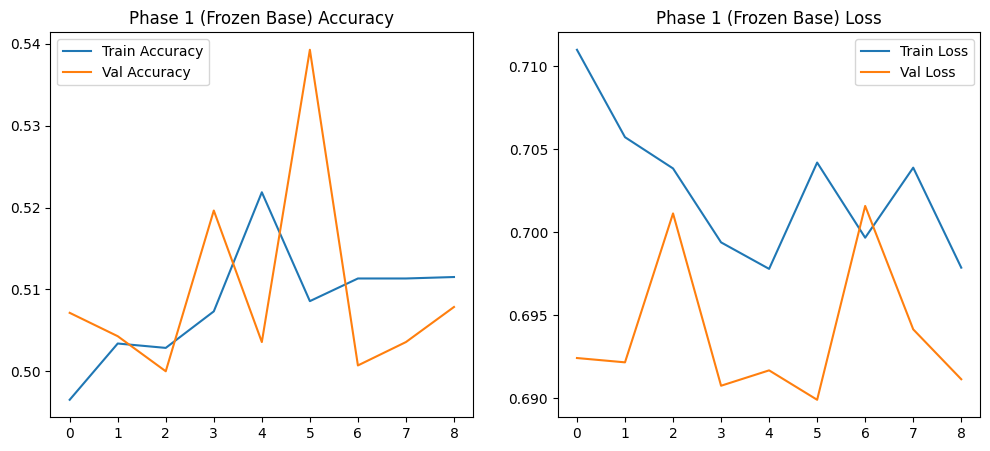

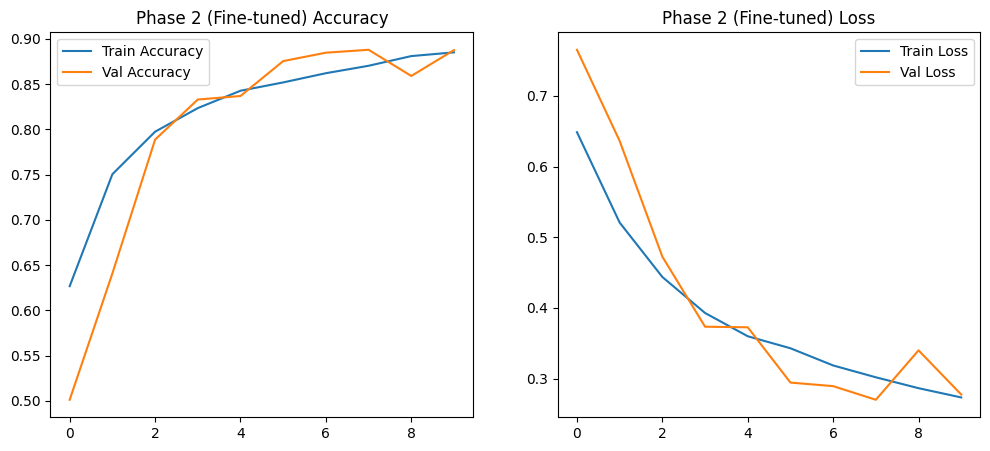

In [ ]:


import matplotlib.pyplot as plt

def plot_training(history, title=""):
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f"{title} Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{title} Loss")
    plt.legend()

    plt.show()

plot_training(history_phase1, "Phase 1 (Frozen Base)")
plot_training(history_phase2, "Phase 2 (Fine-tuned)")


In [ ]:
model.save("final_health_classifier.keras")
print("Final model saved!")

Final model saved!


In [ ]:
#Evaluate model:
oss, acc = model.evaluate(val_data)
print(f"Final Validation Accuracy: {acc*100:.2f}%")


44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 657ms/step - accuracy: 0.8832 - loss: 0.2725
Final Validation Accuracy: 88.61%


2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━

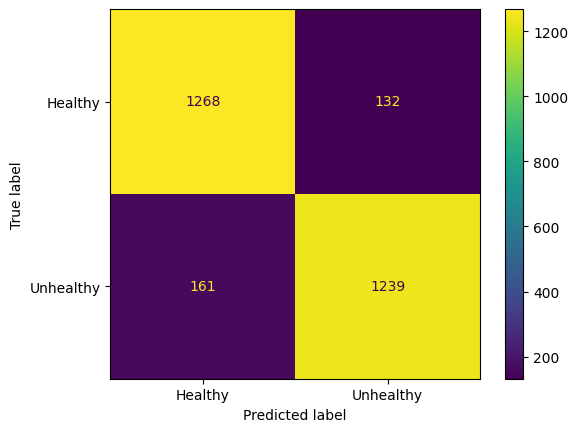

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_true = []
y_pred = []

for x_batch, y_batch in val_data:
    y_true.extend(np.argmax(y_batch, axis=1))
    preds = model.predict(x_batch)
    y_pred.extend(np.argmax(preds, axis=1))
    if len(y_true) >= val_data.samples:
        break

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Unhealthy"])
disp.plot()
plt.show()


In [ ]:
#classification report
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=["Healthy", "Unhealthy"]))


              precision    recall  f1-score   support

     Healthy       0.89      0.91      0.90      1400
   Unhealthy       0.90      0.89      0.89      1400

    accuracy                           0.90      2800
   macro avg       0.90      0.90      0.90      2800
weighted avg       0.90      0.90      0.90      2800

